# Goal
- [x] Train a 1 layer MNIST model
- [x] Add tracking of the digital twin, log that

In [1]:
a=1

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
u.set_enabled_equivalencies(u.dimensionless_angles())

import pickle
import torch
import pytorch_lightning as pl

from tdwg.lib.pl_utils import get_logger
from tdwg.lib.misc_utils import *
from tdwg.lib.plot_utils import *
from tdwg.lib.io_utils import crazy_reload

In [3]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
device = 'cuda' if AVAIL_GPUS else 'cpu'
device = 'cpu'

# Load devices

In [4]:
from tdwg.lib.line_camera import LineCamera
from tdwg.lib.exp_sim_converter import Exp_Sim_Converter
from tdwg.lib.PCIe_beamshaper import PCIe_beamshaper, pos2ind
from tdwg.lib.DMD import DMD
from tdwg.lib.multiuser_client import Client
from tdwg.lib.tdwgnet import TDwgExperiment, FineTunedSimulation, TDwg, TDwgLayer
from tdwg.lib.mode_utils import *

In [5]:
exp_mode = "local"
beamshaper = PCIe_beamshaper(mode=exp_mode)
linecam = LineCamera(mode=exp_mode)
dmd = DMD(mode=exp_mode)
client = Client(online_flag=False)

Blink SDK was successfully constructed
Found 1 SLM controller(s)
Loading library: C:/Program Files/ALP-4.2/ALP-4.2 high-speed API/x64/alpV42.dll
DMD found, resolution = 1024 x 768.


In [64]:
with open('calibration_dict.pkl', 'rb') as file:
    calibration_dict = pickle.load(file)

In [65]:
linecam.load_calibration(calibration_dict)
beamshaper.load_calibration(calibration_dict)
dmd.load_calibration(calibration_dict)

converter = Exp_Sim_Converter(calibration_dict, Ncom=3)
wg = converter.wg

In [66]:
#Make the load come out in eval mode by default... 
#Much safer!
tdwg_sim = FineTunedSimulation(converter)
tdwg_sim.load_state_dict(torch.load('tdwg_sim.pth'))
# tdwg_sim.load_state_dict(torch.load('tdwg_sim_12-28.pth'))

<All keys matched successfully>

In [67]:
tdwg_exp = TDwgExperiment(converter, linecam, beamshaper, dmd, client, calibration_dict)

# Test experiment quickly
If this doesn't work - we are screwed!

In [68]:
tdwg_exp.update_cam_background()

In [69]:
from tdwg.lib.beams_utils import *
from tdwg.lib.DMD_patterns import *
import time

w0 = 40*u.um
xcenter = 0*u.um#(calibration_dict["ind_beam_center"]-455)*calibration_dict["img_exp_pitch"]
input_beam_bs = get_gaussian(beamshaper.x_bs, xcenter, w0, 0/u.mm)

ind_center_shift = int(xcenter / calibration_dict['img_exp_pitch'])

#Some of these images are useful for testing the holography setup
st_size = 10
ycenter = 612 - ind_center_shift
factor = 1.0
img_sawtooth = generate_sawtooth(2*st_size, height=st_size, ycenter=ycenter)
img_sawtooth_invert = invert_pattern(img_sawtooth)
img_off = generate_all_off()
img_on = generate_all_on()

img_bs_1 = factor*img_sawtooth
img_bs_2 = factor*img_sawtooth_invert

dmd.apply_image_hold(img_bs_1)

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:243: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
5 pixels are saturated!
  warnings.warn(warn_msg)


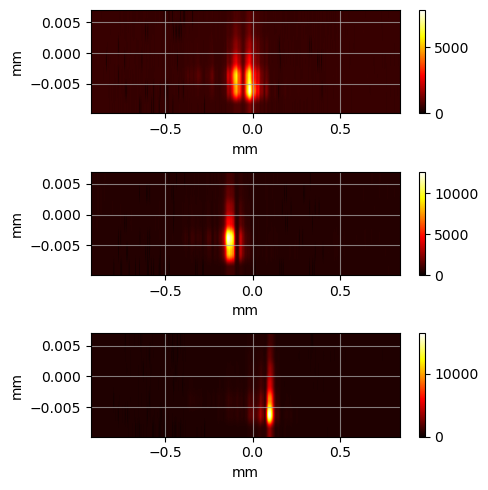

In [78]:
custom_mkdir("calibration_fig")
custom_mkdir("calibration_fig/teeth_bs")

#rewrite linecam code briefly, so we can save this stuff more easily...
fig, axs = plt.subplots(3, 1, figsize=(5, 5), dpi=100)

with client.locked():
    beamshaper.apply_Ein(input_beam_bs, 0.3)

    dmd.apply_image_hold(img_on)
    time.sleep(0.5)
    plt.sca(axs[0])
    linecam.show_image(fig_flag=False)

    dmd.apply_image_hold(img_bs_1)
    time.sleep(0.5)
    plt.sca(axs[1])
    linecam.show_image(fig_flag=False)

    dmd.apply_image_hold(img_bs_2)
    time.sleep(0.5)
    plt.sca(axs[2])
    linecam.show_image(fig_flag=False)

plt.savefig(f"calibration_fig/teeth_bs/{timestring()}.png", dpi=100, bbox_inches="tight")

# Train insilico once

In [14]:
from tdwg.datasets.mnist_dataset import *
"""Create datasets"""
train_dataset, val_dataset, test_dataset = create_MNIST_datasets(label_list = 
                                            [0,1,2,3,4,5,6,7,8,9])

"""Create input/output modes"""
Nin = 49
Nout = 10
w0_in = 6*u.um
xmode_in_lim = 200*u.um
xmode_out_lim = 300*u.um

In [15]:
# Parameters of the model!
pname = "MNIST_1lay_pat"
lr = 3e-2
gamma = 0.9
batch_size = 64

lag_amp = 2
factor = 20

In [82]:
m_factor = 0.6
N_hidden = 49

In [17]:
crazy_reload("tdwg.lib.tdwgnet", globals())

In [18]:
from tdwg.lib.custom_plmodels import *
from tdwg.lib.pl_utils import *

crazy_reload("tdwg.lib.custom_plmodels", globals())
crazy_reload("tdwg.lib.pl_utils", globals())

class PNN(pl.LightningModule):
    """
    This class represents the PNN, which consists of digital parameters, 
    input and output encoding procedures, 2Dwg layers and 
    code for training + validation steps.
    """
    def __init__(self, mode, seed = 'identity'):
        super().__init__()
        self.tdwg_layer = TDwgLayer(tdwg_exp, tdwg_sim, mode, Nin, 10, w0_in, 
                                      xmode_in_lim, xmode_out_lim, seed=seed, random_flag=True)
        self.mult = SingleMult(0.5)
        # self.tdwg_layer_3 = TDwgLayer(tdwg_exp, tdwg_sim, mode, N_hidden, Nout, w0_in, xmode_in_lim, xmode_out_lim, seed=seed)
        # self.skip2 = Skip()
        
    def forward(self, x):
        # x = ft_downsampling(x)
        x = avgpool_downsampling(x)

        x = self.tdwg_layer(x)
        x = self.mult(x)
        logits = F.log_softmax(x, dim=1)

        self.save_dict = dict()
        for (name, module) in self.named_modules():
            if hasattr(module, "save_dict"):
                self.save_dict[name] = module.save_dict
        
        return logits

# Call the PNN 
mode = "insilico"
pnn = PNN(mode)

#### Write the lagrangian
from tdwg.lib.pnn_utils import lagrangian

def lag_func(pnn):
    lag1 = lagrangian(pnn.tdwg_layer.tdwg, 
                                lag_amp = lag_amp, factor = factor)
    return lag1 


# Instantiate the model
model = LagrangePlModel(train_dataset, val_dataset, test_dataset,
                      pnn, lag_func, learning_rate=lr, gamma=gamma, 
                        save_outputs_every_n_epochs=1)

In [19]:
model.to("cpu")
torch.manual_seed(0)
x, y = next(iter(model.train_dataloader()))
model.training_step((x, y), 0)

C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\core\module.py:420: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(2.3648, dtype=torch.float64, grad_fn=<AddBackward0>)

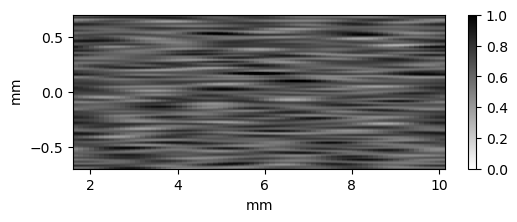

In [20]:
plt.pcolormesh(converter.z_axis_sim_window, wg.x_axis, model.pnn.tdwg_layer.tdwg.mod_sim_window.detach(), vmin=0, vmax=1.0, cmap="binary")
plt.ylim(-0.7, 0.7)
plt.colorbar()

In [20]:
from pytorch_lightning.callbacks import LearningRateMonitor
from tdwg.lib.misc_utils import timestring

name = f"{mode}_avgpool_pure_300um"

check_val_every_n_epoch = 1
logger = get_logger(pname, name)

log_dir = get_log_dir(pname, name)
checkpoint_cb = pl.callbacks.ModelCheckpoint(log_dir, 
                 every_n_train_steps = 800, save_top_k=-1)

lr_monitor = LearningRateMonitor(logging_interval='epoch')  # or 'epoch'

trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=20,
    logger = logger, 
    check_val_every_n_epoch = 1,
    log_every_n_steps = 20, 
    callbacks=[checkpoint_cb, lr_monitor],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA RTX A4500') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mstein (pnn). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params
----------------------------------------------
0 | pnn    | PNN                | 281 K 
1 | metric | MulticlassAccuracy | 0     
----------------------------------------------
73.7 K    Trainable params
207 K     Non-trainable params
281 K     Total params
1.126     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# Run PAT code now!

In [79]:
from tdwg.lib.pl_callback import check_digital_twins

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
3 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
2 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
4 pixels are saturated!
  warnings.warn(warn_msg)


(0.0017289481307047334, 0.0001913454132593327)

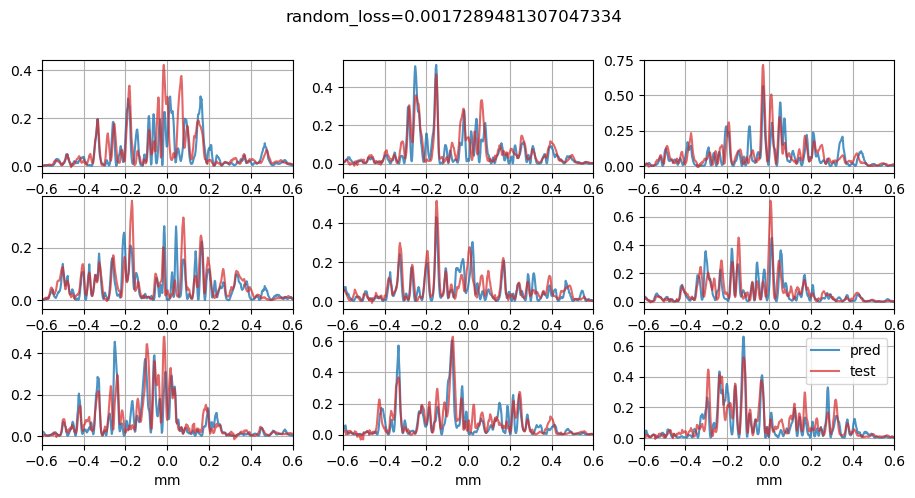

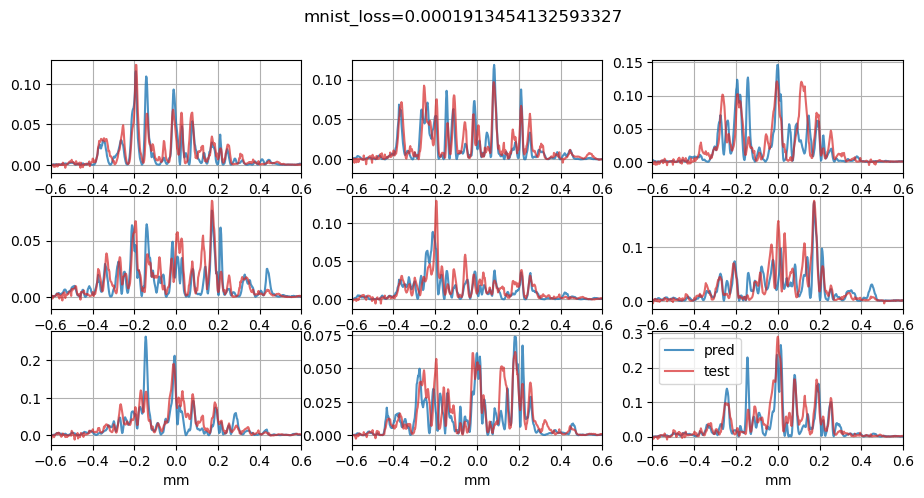

In [80]:
check_digital_twins(tdwg_exp, tdwg_sim, close_fig=False)

In [41]:
# Call the PNN 
mode = "pat"
pnn = PNN(mode)

# Instantiate the model
model = LagrangePlModel(train_dataset, val_dataset, test_dataset,
                      pnn, lag_func, learning_rate=lr, gamma=gamma, 
                        save_outputs_every_n_epochs=1)

In [42]:
model.to("cpu")
torch.manual_seed(0)
x, y = next(iter(model.train_dataloader()))
model.training_step((x, y), 0)

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
1 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
3 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\core\module.py:420: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(2.2516, dtype=torch.float64, grad_fn=<AddBackward0>)

In [43]:
from tdwg.lib.pl_callback import *
check_dt_callback = Check_DT_Callback(tdwg_exp, tdwg_sim, 400)

In [44]:
from pytorch_lightning.callbacks import LearningRateMonitor
from tdwg.lib.misc_utils import timestring

name = f"{mode}_1lay_pure"

logger = get_logger(pname, name)

log_dir = get_log_dir(pname, name)
checkpoint_cb = pl.callbacks.ModelCheckpoint(log_dir, 
                 every_n_train_steps = 100, save_top_k=-1)

lr_monitor = LearningRateMonitor(logging_interval='epoch')  # or 'epoch'

trainer = pl.Trainer(
    accelerator="cpu",
    max_epochs=30,
    logger = logger, 
    check_val_every_n_epoch = 1,
    log_every_n_steps = 2, 
    callbacks=[checkpoint_cb, lr_monitor, check_dt_callback],
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [ ]:
trainer.fit(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mstein (pnn). Use `wandb login --relogin` to force relogin



  | Name   | Type               | Params
----------------------------------------------
0 | pnn    | PNN                | 281 K 
1 | metric | MulticlassAccuracy | 0     
----------------------------------------------
73.7 K    Trainable params
207 K     Non-trainable params
281 K     Total params
1.126     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
4 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
2 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\.conda\envs\tdwg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_w

Training: |                                                                                      | 0/? [00:00<…

C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
1 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
5 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
3 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdwg\lib\line_camera.py:172: UserWarning: There is saturation on camera!
6 pixels are saturated!
  warnings.warn(warn_msg)
C:\Users\McMahon-lab\McMahon lab Dropbox\peter mcmahon\to232\2D-waveguide\2024-01-03 5volt operation\tdw

In [46]:
a=1

# Take a look at trained patterns

(-0.7, 0.7)

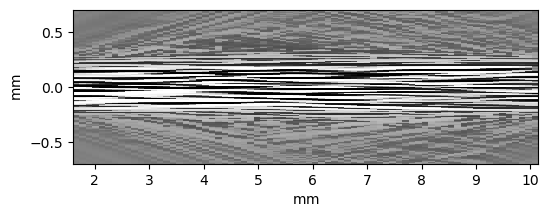

In [35]:
mod_sim_window = model.pnn.tdwg_layer.tdwg.mod_sim_window.detach()
plt.pcolormesh(converter.z_axis_sim_window, wg.x_axis, mod_sim_window,
               vmin=0, vmax=1.0, cmap="binary")
plt.ylim(-0.7, 0.7)